# **PROJECT JARINGAN SYARAF TIRUAN - BACPROPAGATION**

## **Library**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ucimlrepo import fetch_ucirepo
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import ADASYN
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

seed = 42

In [2]:
# Activating GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is activated")
    except:
        print("Could not set memory growth")

GPU is activated


## **Data**
Data source = [UC Irvine Machine Learning Repository: Default of Credit card](https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients)

In [3]:
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 

# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 

# variable information 
print(default_of_credit_card_clients.variables) 

   name     role     type      demographic                 description units  \
0    ID       ID  Integer             None                        None  None   
1    X1  Feature  Integer             None                   LIMIT_BAL  None   
2    X2  Feature  Integer              Sex                         SEX  None   
3    X3  Feature  Integer  Education Level                   EDUCATION  None   
4    X4  Feature  Integer   Marital Status                    MARRIAGE  None   
5    X5  Feature  Integer              Age                         AGE  None   
6    X6  Feature  Integer             None                       PAY_0  None   
7    X7  Feature  Integer             None                       PAY_2  None   
8    X8  Feature  Integer             None                       PAY_3  None   
9    X9  Feature  Integer             None                       PAY_4  None   
10  X10  Feature  Integer             None                       PAY_5  None   
11  X11  Feature  Integer             No

This research employed a binary variable, default payment **(Yes = 1, No = 0)**, as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- **X1**: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- **X2**: Gender (1 = male; 2 = female).
- **X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- **X4**: Marital status (1 = married; 2 = single; 3 = others).
- **X5**: Age (year).
- **X6 - X11**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- **X12-X17**: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- **X18-X23**: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [4]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [5]:
y.head()

,Y
0,1
1,1
2,0
3,0
4,0


### **Removing Invalid Values**
After checking, several data were found that did not match the scale in the variable description. After inspection, several data points were found to be off-scale in the variable descriptions. This data was found in variables X3 and X4.

In [6]:
# Handle invalid values in X2 and X4 by setting them to NaN
X.loc[~X['X3'].isin([1, 2, 3, 4]), 'X3'] = np.nan
X.loc[~X['X4'].isin([1, 2, 3]), 'X4'] = np.nan

print("X3 value counts after cleaning:")
print(X['X3'].value_counts(dropna=False))
print("\nX4 value counts after cleaning:")
print(X['X4'].value_counts(dropna=False))

X3 value counts after cleaning:
2.0    14030
1.0    10585
3.0     4917
NaN      345
4.0      123
Name: X3, dtype: int64

X4 value counts after cleaning:
2.0    15964
1.0    13659
3.0      323
NaN       54
Name: X4, dtype: int64


In [7]:
data = pd.concat([X, y], axis=1)
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2.0,1.0,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2.0,2.0,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2.0,2.0,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2.0,1.0,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2.0,1.0,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3.0,1.0,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3.0,2.0,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2.0,2.0,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3.0,1.0,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### **Statistic Descriptive**

In [8]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
count,30000.000000,30000.000000,29655.000000,29946.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.817164,1.554665,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.711283,0.518259,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [9]:
data.isnull().sum()

X1       0
X2       0
X3     345
X4      54
X5       0
X6       0
X7       0
X8       0
X9       0
X10      0
X11      0
X12      0
X13      0
X14      0
X15      0
X16      0
X17      0
X18      0
X19      0
X20      0
X21      0
X22      0
X23      0
Y        0
dtype: int64

In [10]:
missing_percentage = data.isnull().mean() * 100
missing_percentage

X1     0.00
X2     0.00
X3     1.15
X4     0.18
X5     0.00
X6     0.00
X7     0.00
X8     0.00
X9     0.00
X10    0.00
X11    0.00
X12    0.00
X13    0.00
X14    0.00
X15    0.00
X16    0.00
X17    0.00
X18    0.00
X19    0.00
X20    0.00
X21    0.00
X22    0.00
X23    0.00
Y      0.00
dtype: float64

In [11]:
data.duplicated().sum()

35

In [12]:
duplicate_precentage = (data.duplicated().sum() / len(data)) * 100
print(f"Percentage of duplicate rows: {duplicate_precentage:.2f}%")

Percentage of duplicate rows: 0.12%


## **EDA**

In [13]:
num_features = data.drop(['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'Y'], axis=1).columns
cat_features = data[['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']].columns

print("Numerical Features:", num_features.tolist())
print("Categorical Features:", cat_features.tolist())

Numerical Features: ['X1', 'X5', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
Categorical Features: ['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']


### **Feature Distribution**

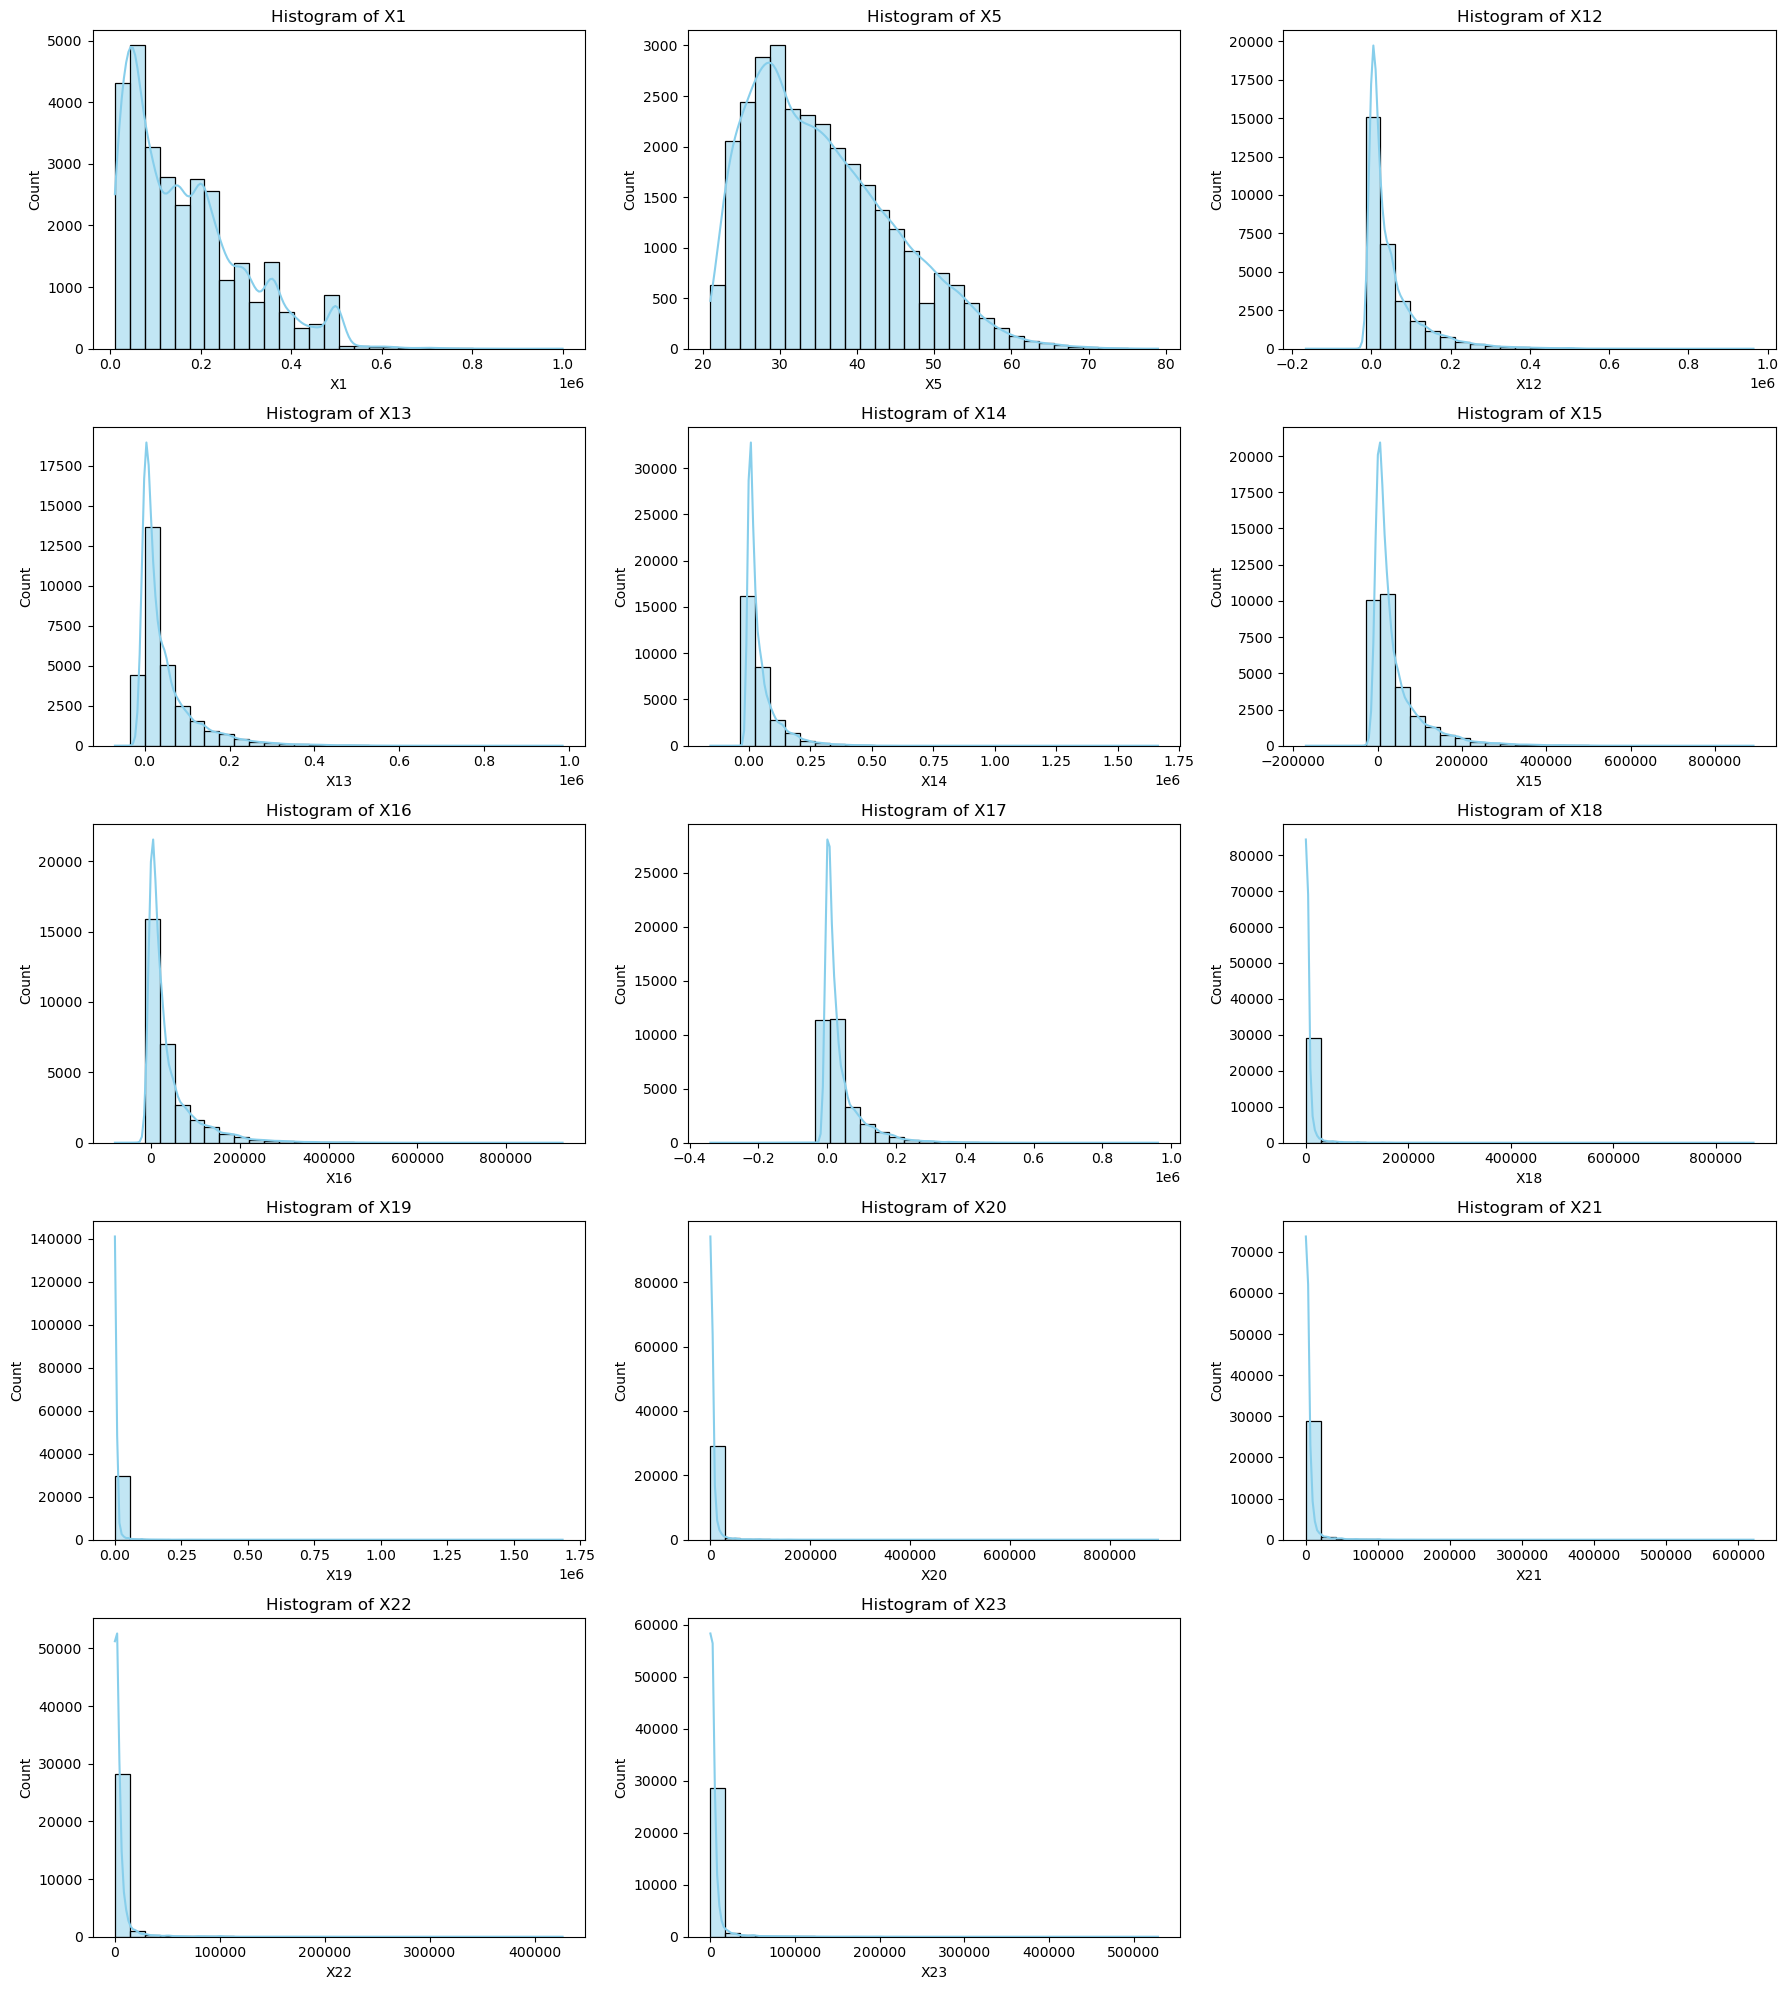

In [14]:
# visualize the distribution of the numerical features
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    sns.histplot(data[column], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {column}')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

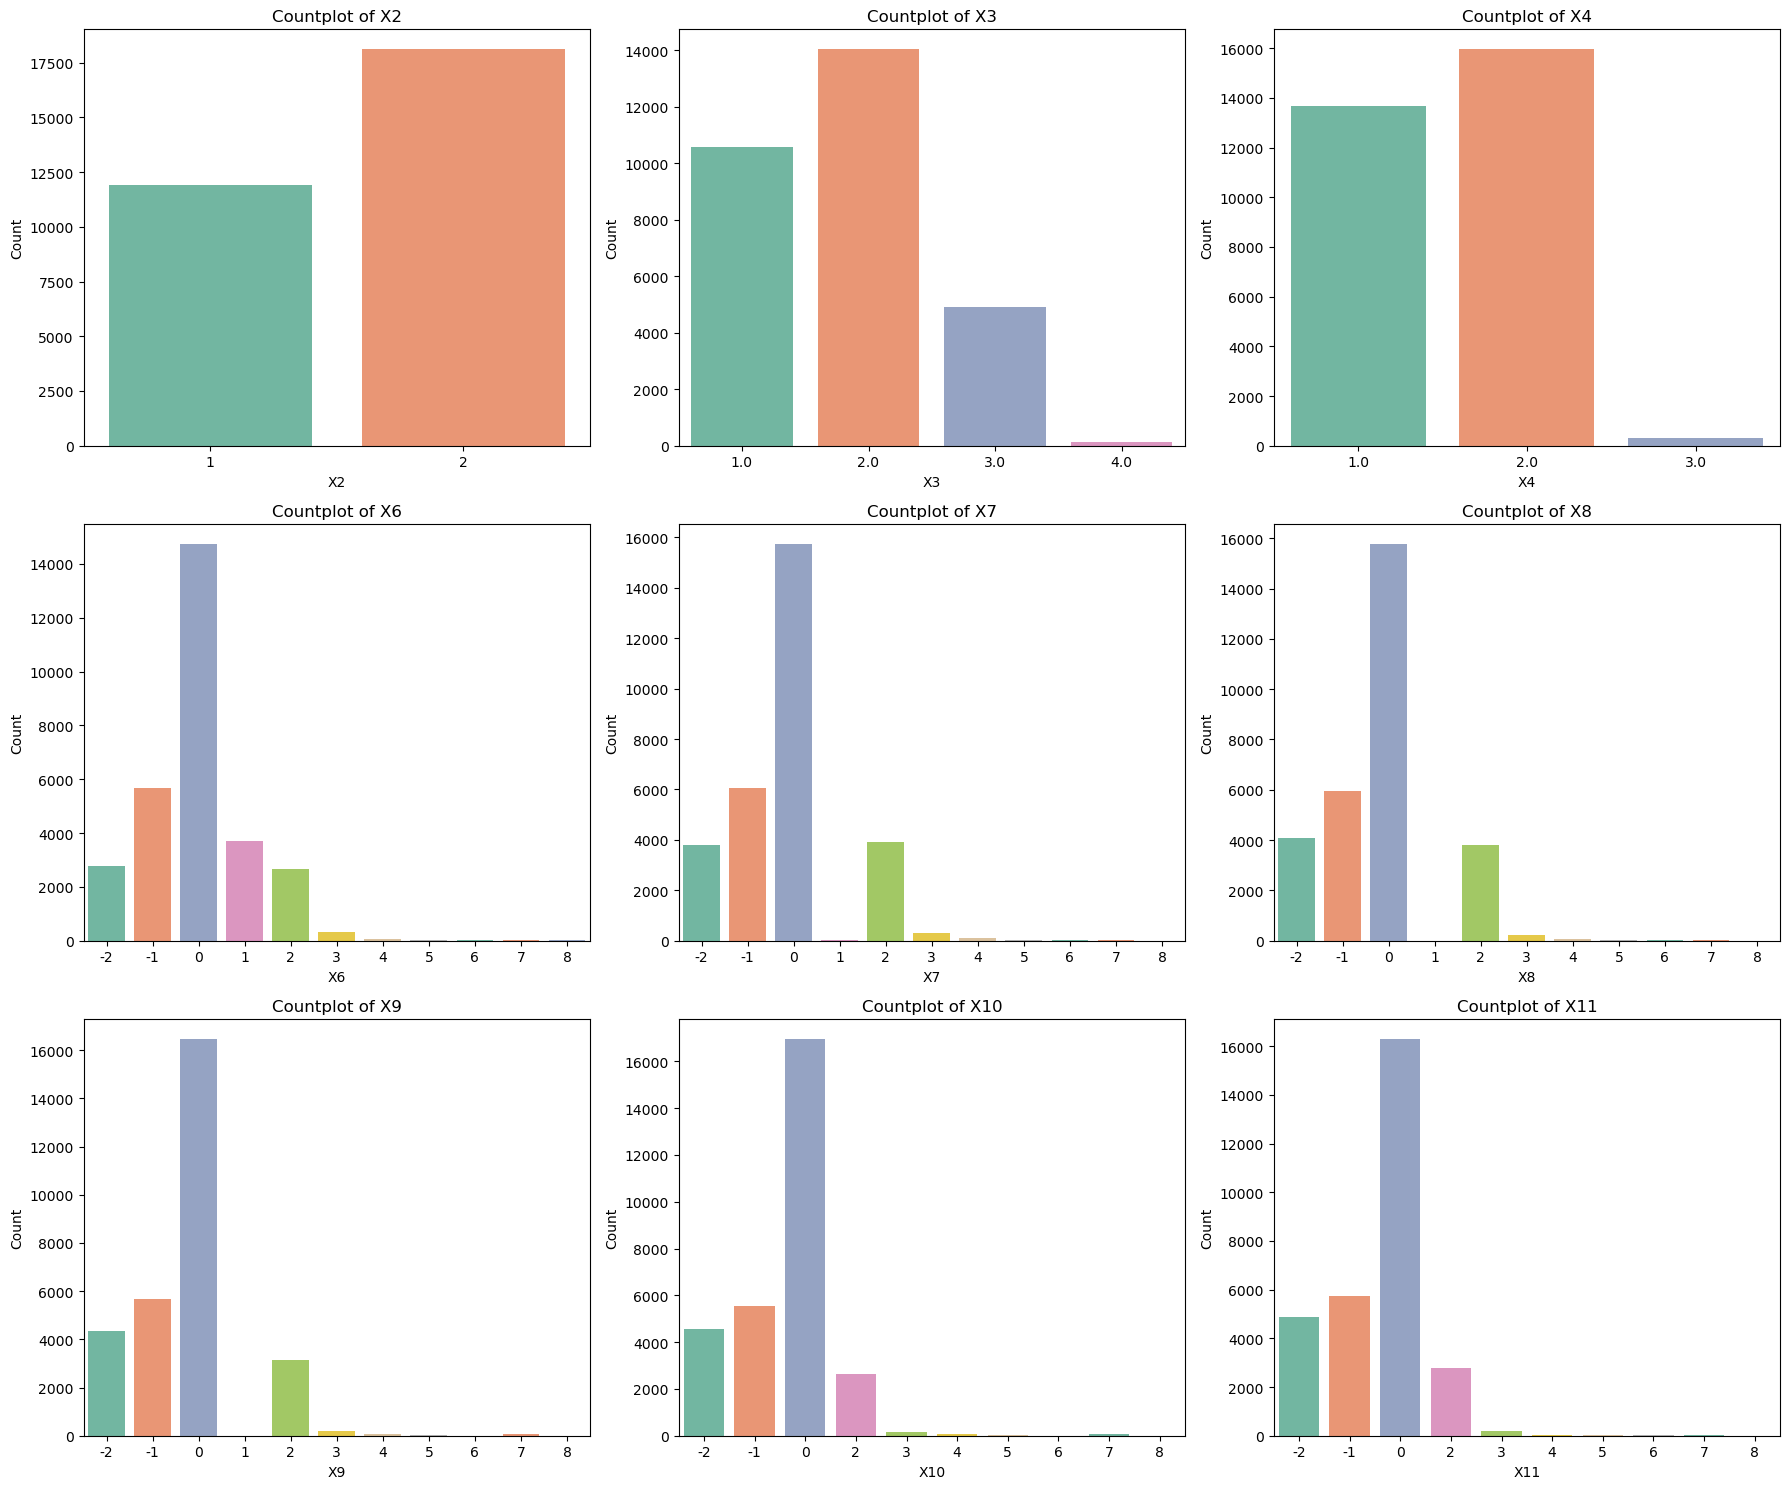

In [15]:
# visualization of categorical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()
for i, column in enumerate(cat_features):
    sns.countplot(x=data[column], ax=axes[i], palette='Set2')
    axes[i].set_title(f'Countplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

### **Boxplot**

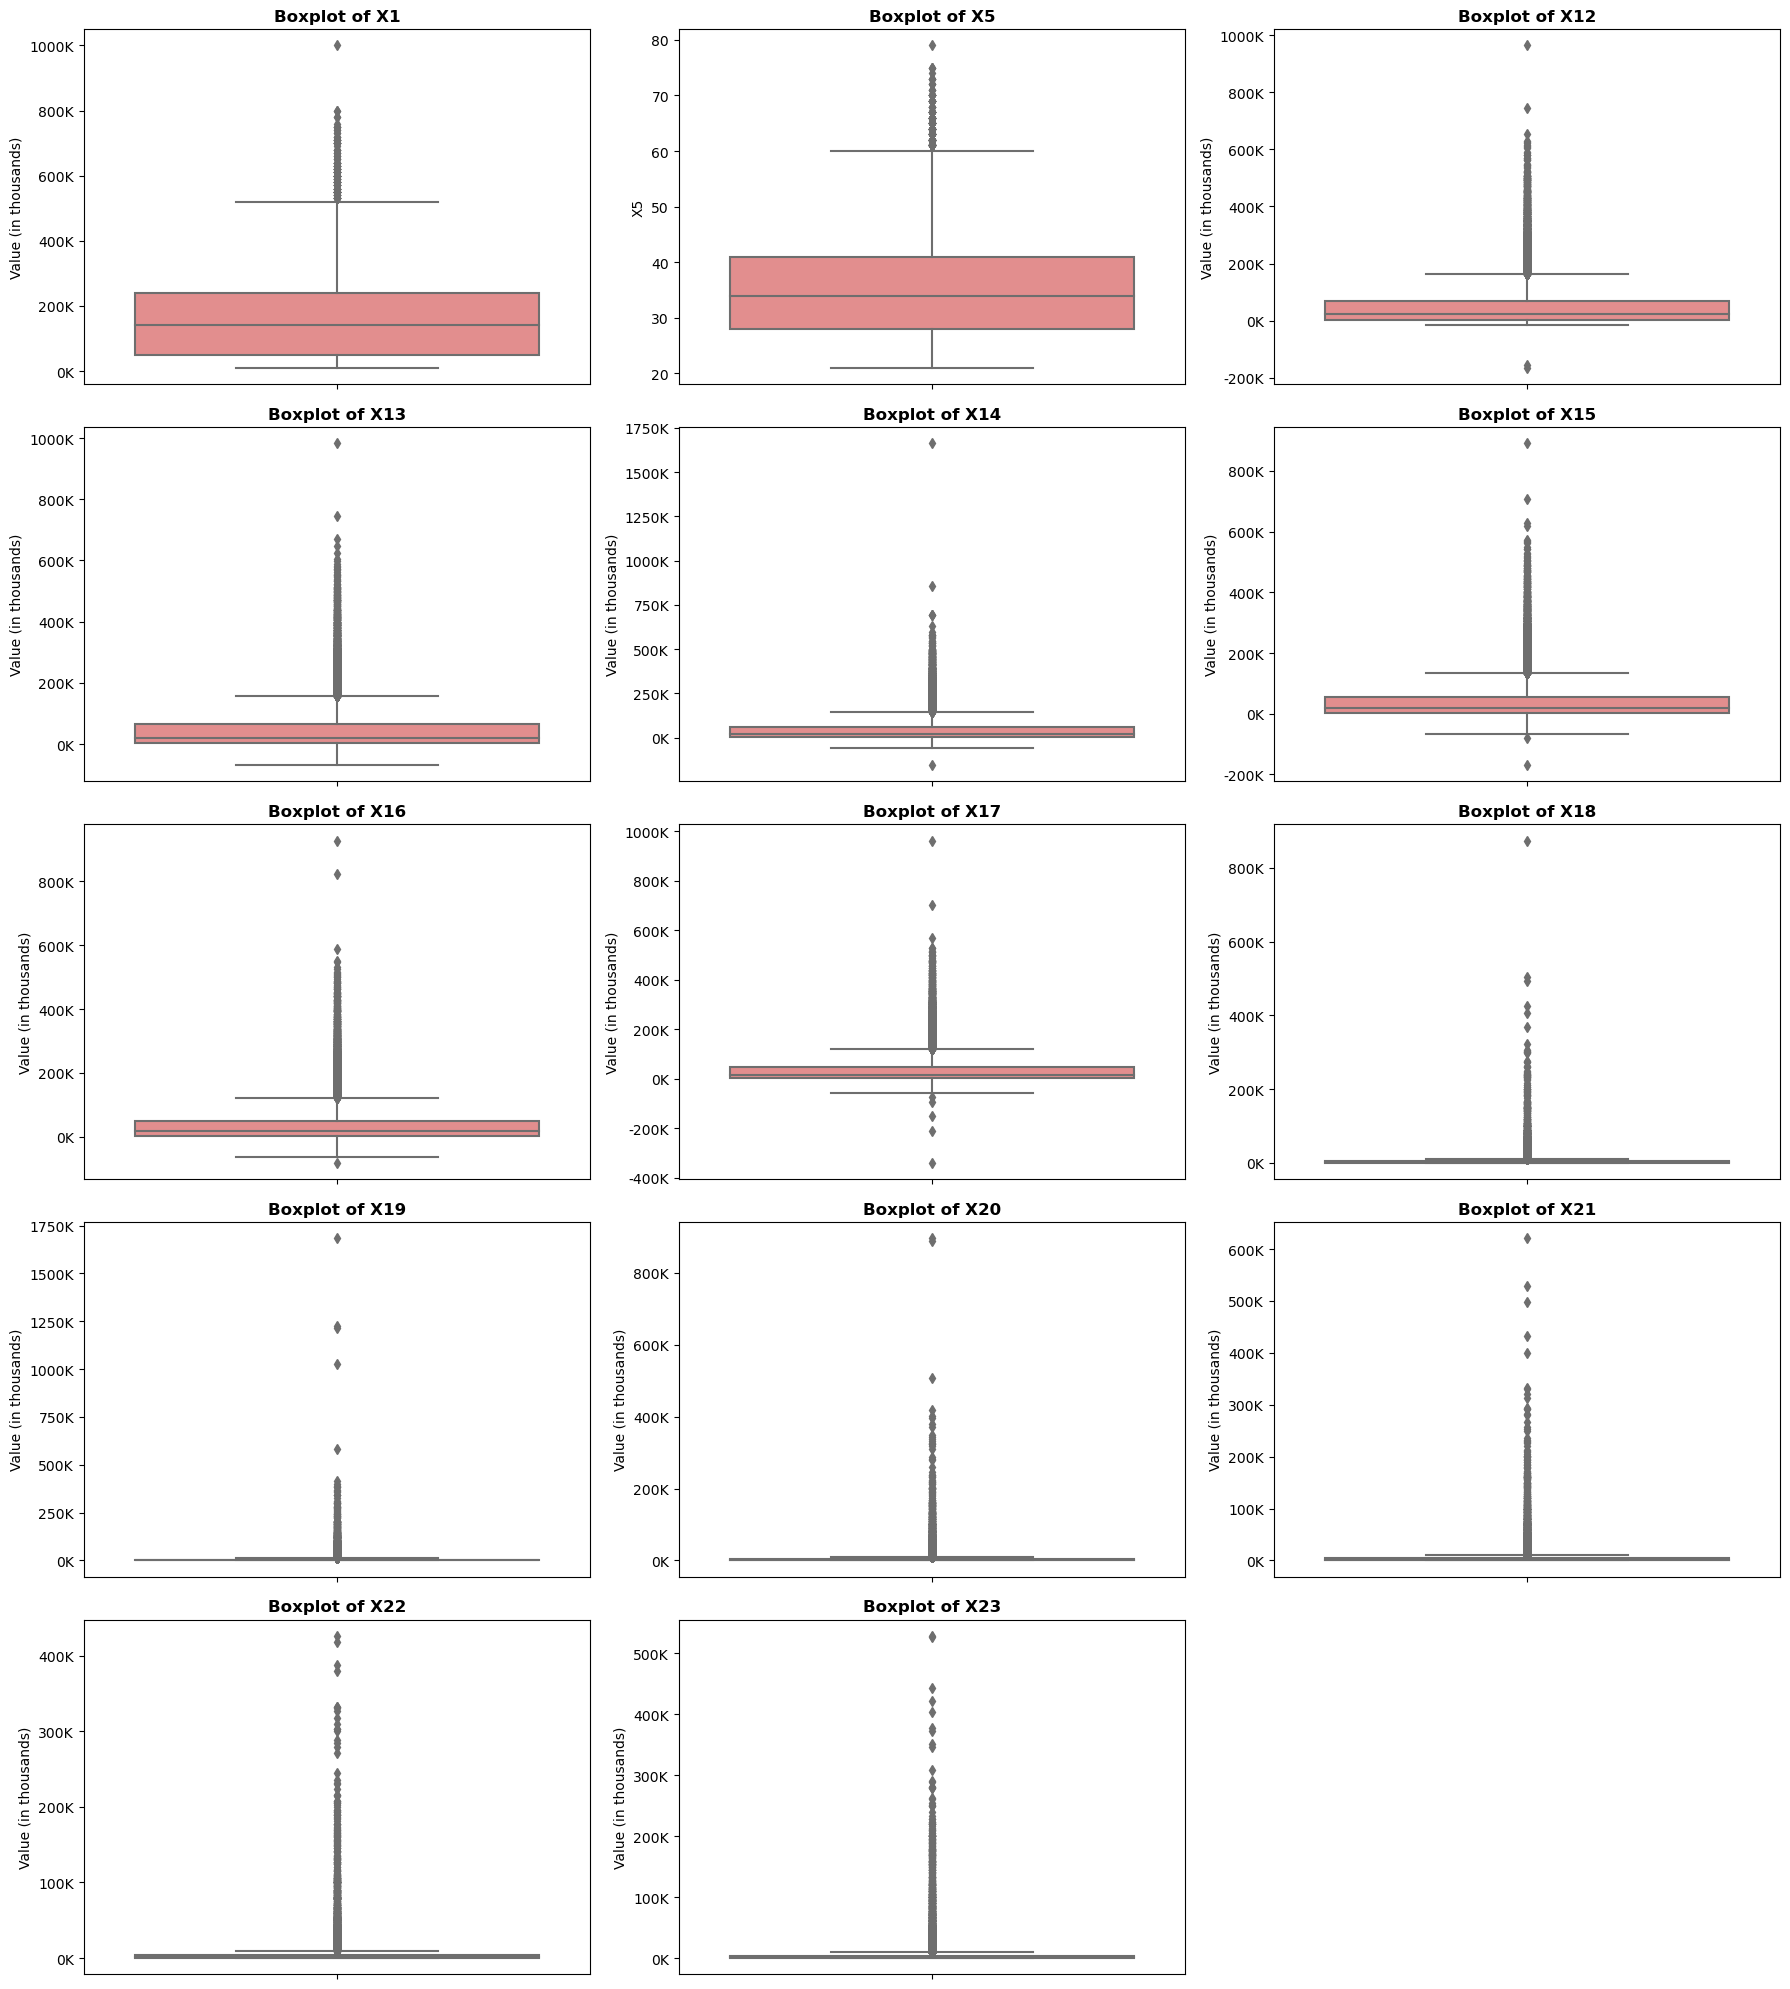

In [16]:
# Boxplot for checking outliers
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    # Create boxplot
    sns.boxplot(y=data[column], ax=axes[i], color='lightcoral')
    axes[i].set_title(f'Boxplot of {column}', fontsize=12, fontweight='bold')
    
    # Format y-axis for better readability
    if data[column].max() > 10000:
        axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
        axes[i].set_ylabel('Value (in thousands)')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Target Distribution**

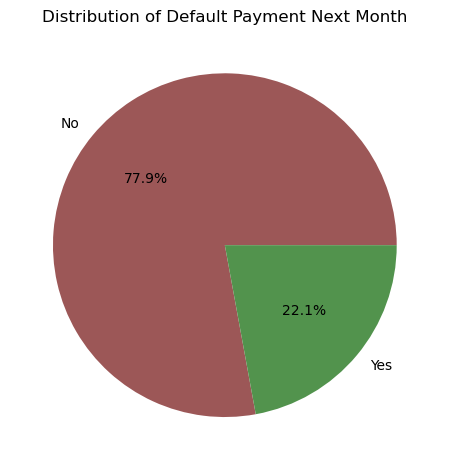

In [17]:
# visualize the distribution of the target variable
plt.pie(data['Y'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%', colors=["#9C5757", "#52934d"])
plt.title('Distribution of Default Payment Next Month')
plt.tight_layout()
plt.show()

### **Correlation**

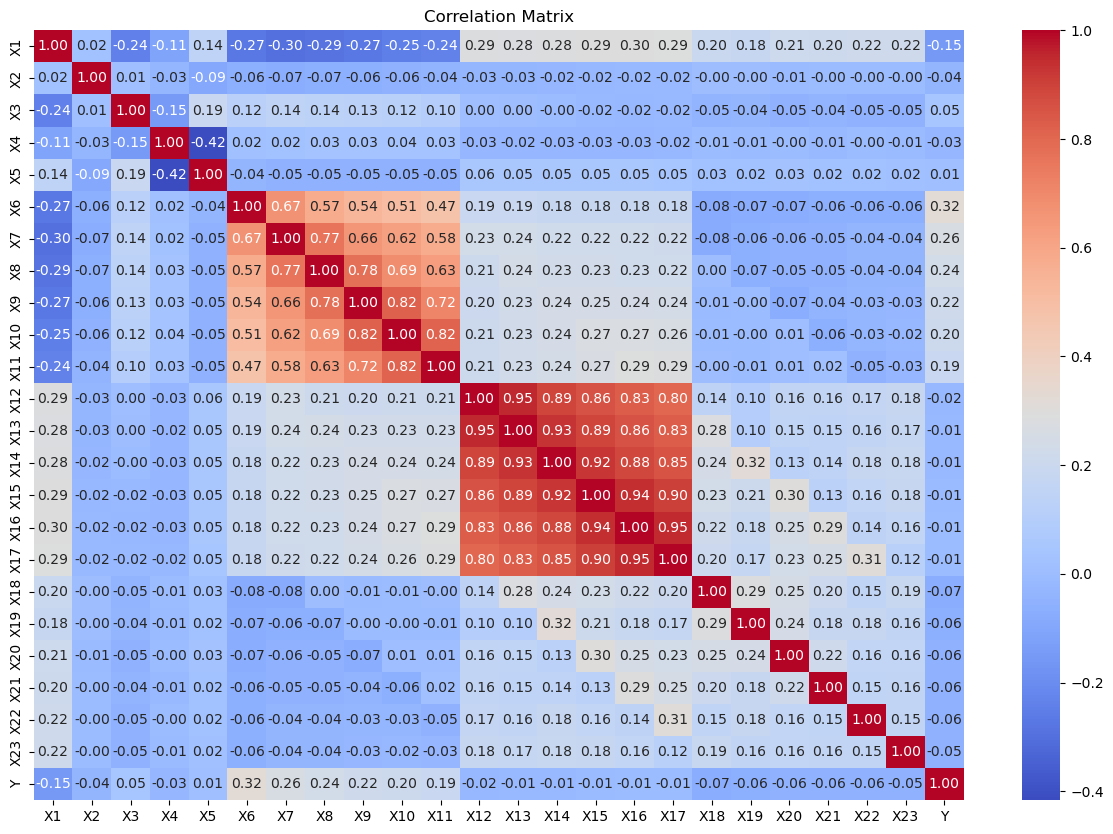

In [18]:
# Correlation matrix
plt.figure(figsize=(15,10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# Calculate correlation matrix to identify highly correlated features
print("Correlation Analysis")

# Create a copy of the data for feature selection
X = data.drop('Y', axis=1)
y = data['Y']

# Calculate correlation matrix
corr_matrix = X.corr()

# Find pairs of features with correlation > 0.8 (high correlation threshold)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

print(f"Found {len(high_corr_pairs)} highly correlated pairs (|r| > 0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")

Correlation Analysis
Found 17 highly correlated pairs (|r| > 0.8):
X9 - X10: 0.820
X10 - X11: 0.817
X12 - X13: 0.951
X12 - X14: 0.892
X12 - X15: 0.860
X12 - X16: 0.830
X12 - X17: 0.803
X13 - X14: 0.928
X13 - X15: 0.892
X13 - X16: 0.860
X13 - X17: 0.832
X14 - X15: 0.924
X14 - X16: 0.884
X14 - X17: 0.853
X15 - X16: 0.940
X15 - X17: 0.901
X16 - X17: 0.946


In [20]:
# Step 2: Calculate VIF (Variance Inflation Factor)
print("VIF Analysis")
def calculate_vif(df):
    # Handle missing values by using only complete cases
    df_clean = df.dropna()
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_clean.columns
    vif_data["VIF"] = [variance_inflation_factor(df_clean.values, i) for i in range(len(df_clean.columns))]
    return vif_data.sort_values('VIF', ascending=False)

vif_scores = calculate_vif(X)
print("VIF scores (VIF > 5 indicates multicollinearity):")
print(vif_scores)

VIF Analysis
VIF scores (VIF > 5 indicates multicollinearity):
   Feature        VIF
12     X13  37.951642
15     X16  36.829180
13     X14  31.963226
14     X15  29.909326
16     X17  22.043252
11     X12  20.709199
4       X5  11.383880
1       X2   9.174396
2       X3   7.844972
3       X4   6.385725
9      X10   4.983232
8       X9   4.440183
0       X1   4.043852
7       X8   3.723280
10     X11   3.459684
6       X7   3.204600
18     X19   2.399473
19     X20   1.917757
5       X6   1.916466
17     X18   1.911203
21     X22   1.876348
20     X21   1.818106
22     X23   1.267015


## **Preprocessing**

### **Handling Missing Values**

In [21]:
imputer = SimpleImputer(strategy='most_frequent')
data[['X3', 'X4']] = imputer.fit_transform(data[['X3', 'X4']])

In [22]:
data.isnull().sum() 

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

### **Handling Outliers**

In [23]:
# handling outliers using winsorization
data = data.copy()
for col in num_features:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    iqr = Q3 - Q1
    lower_bound = Q1 - 1.5 * iqr
    upper_bound = Q3 + 1.5 * iqr
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

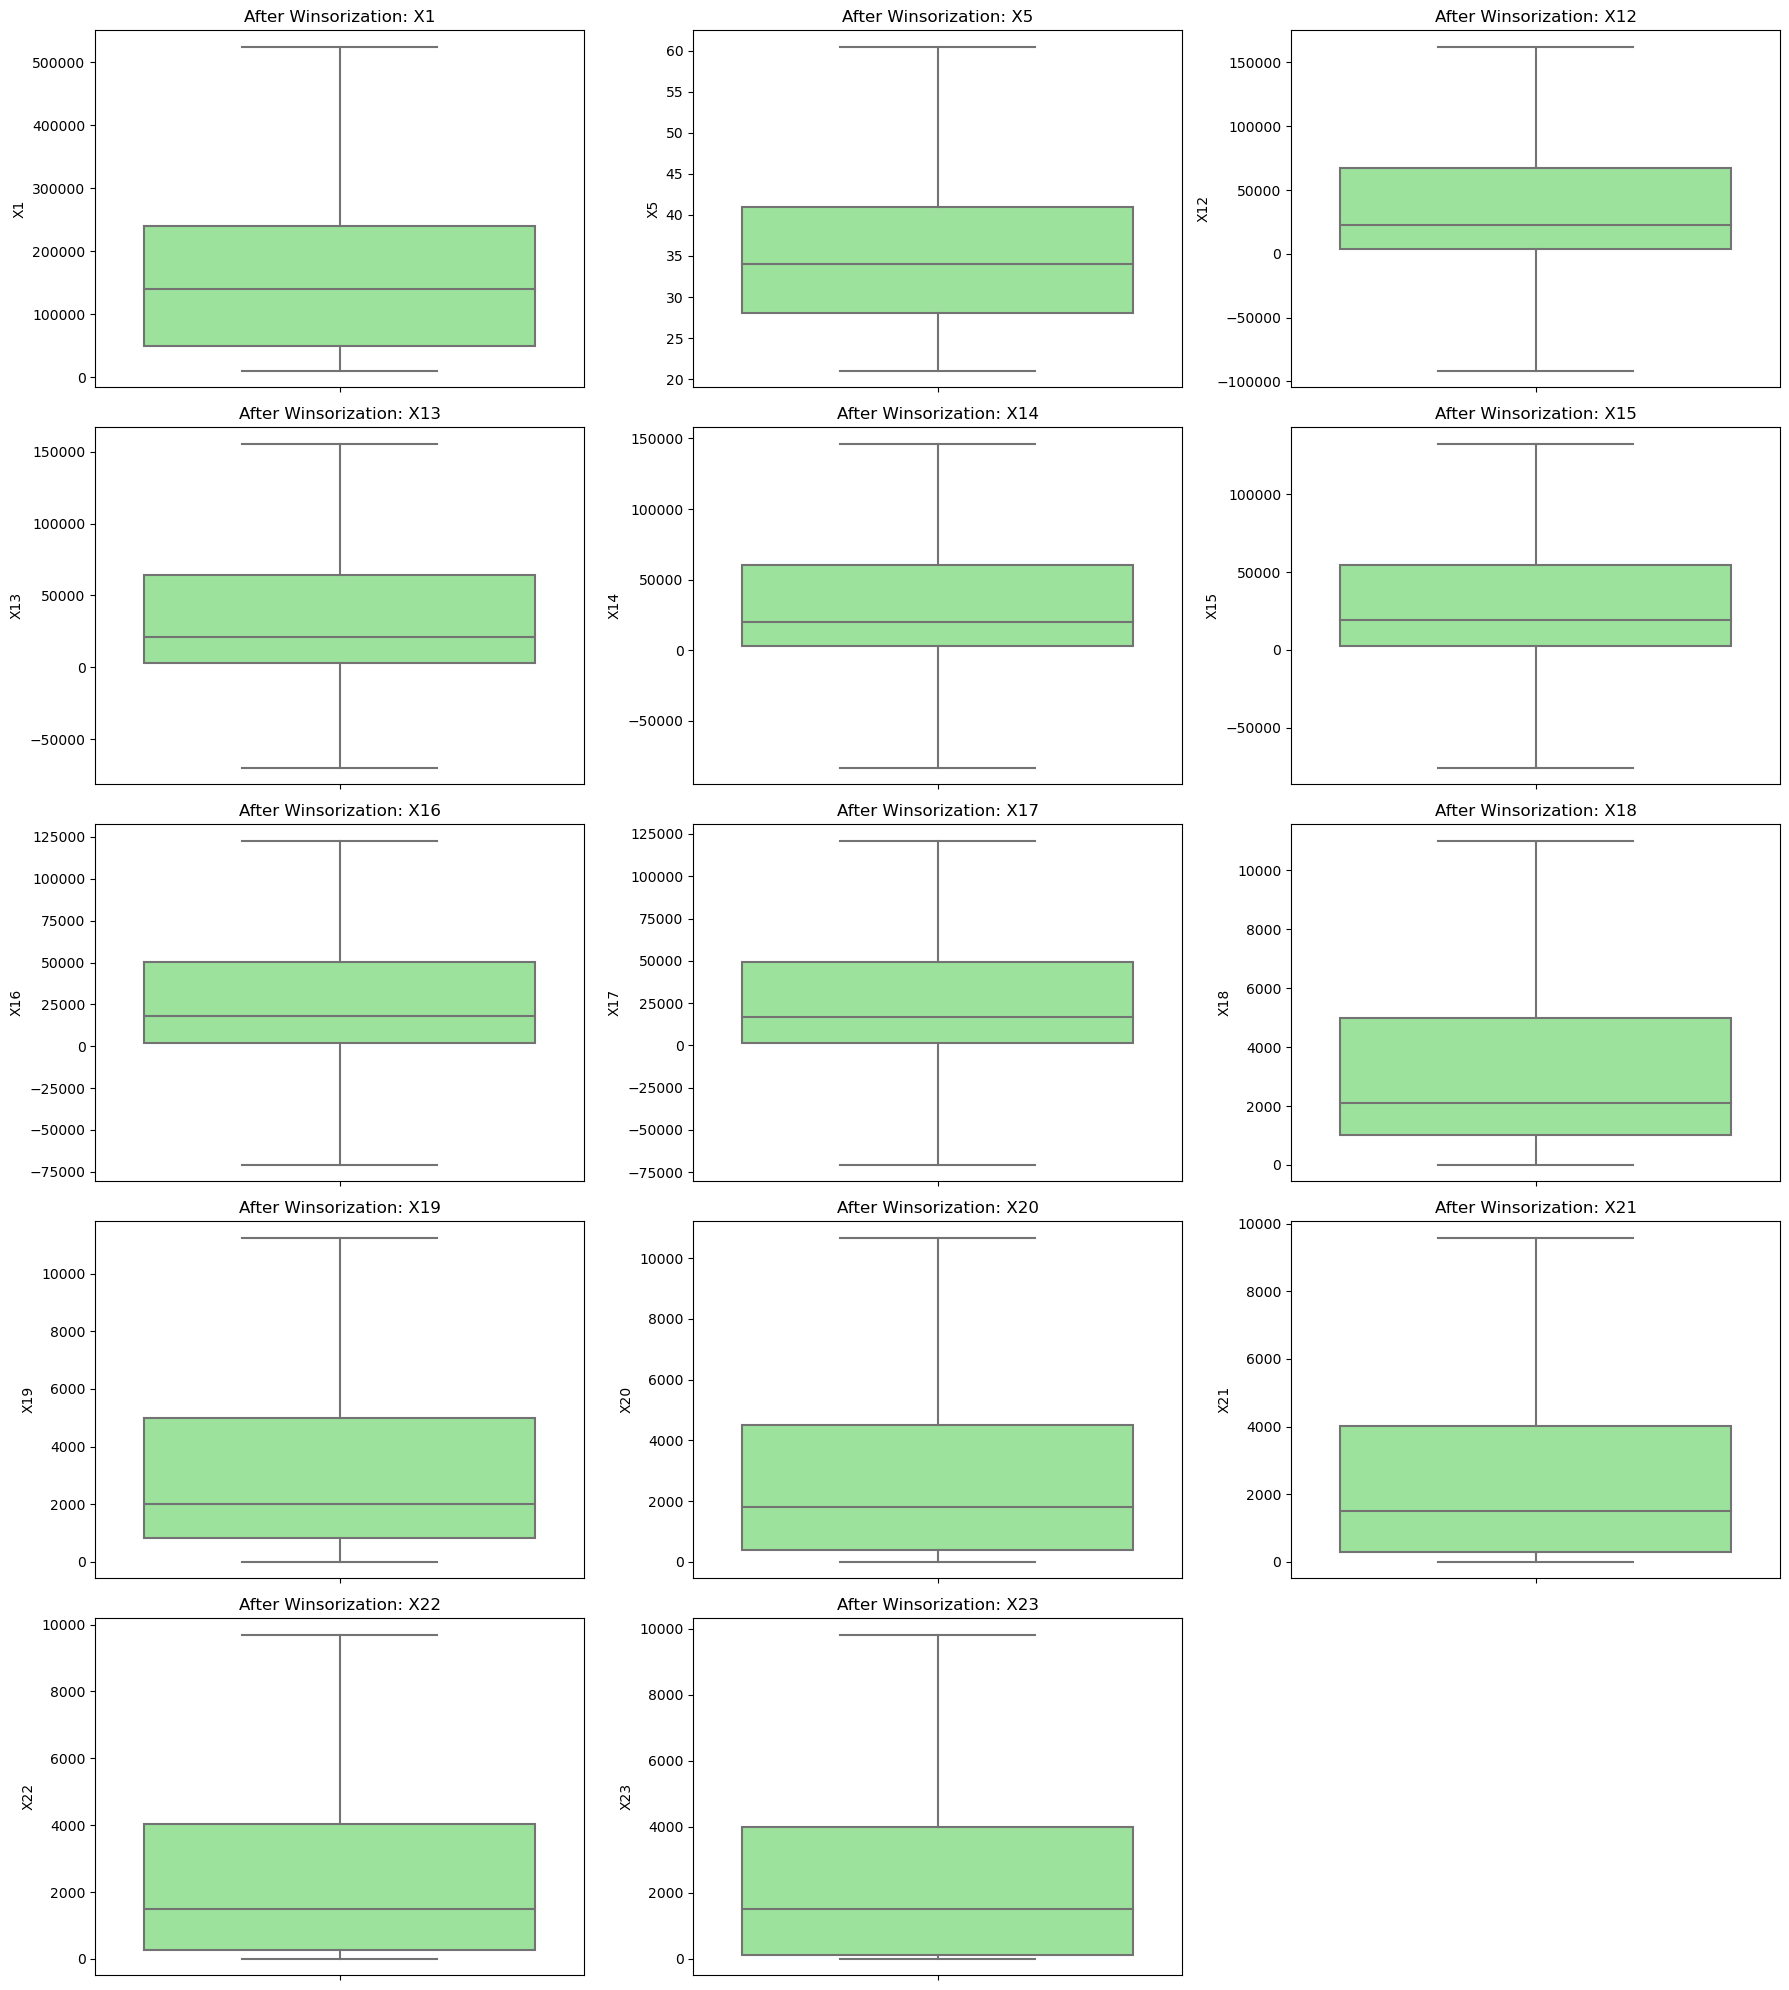

In [24]:
# boxplot after handling outliers
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(data[num_features].columns):
    sns.boxplot(y=data[column], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'After Winsorization: {column}')
# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

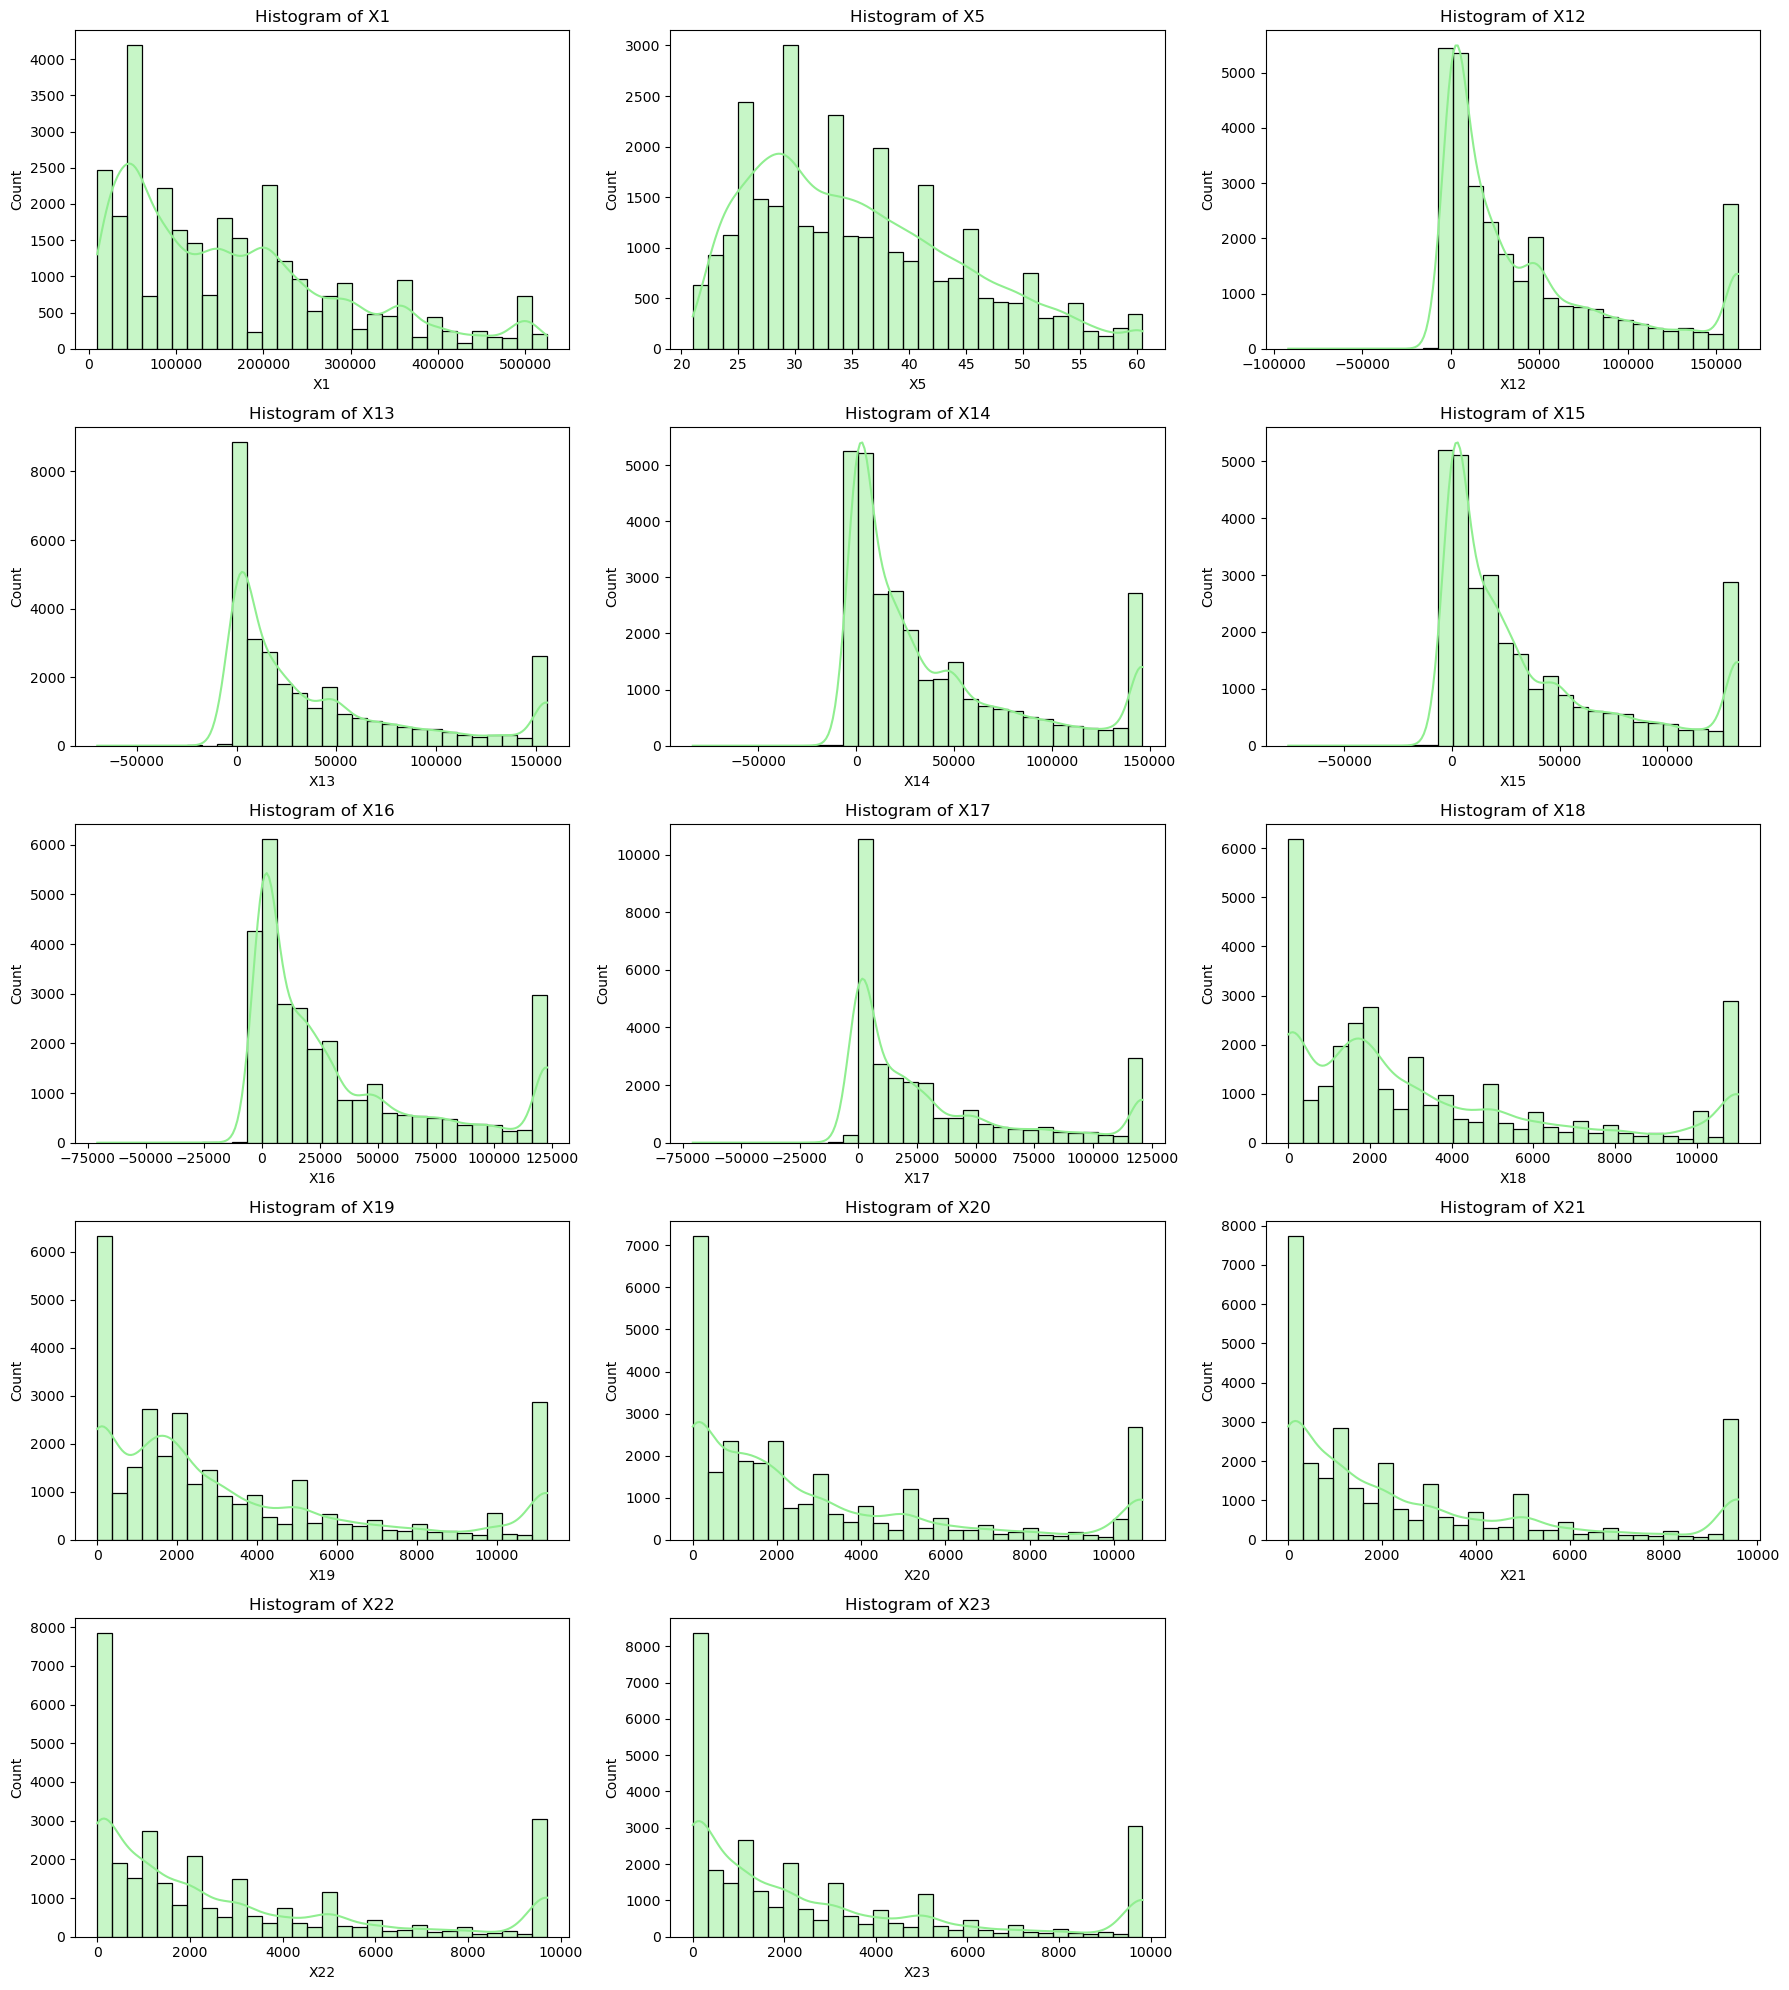

In [25]:
# visualize the distribution of the numerical features
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    sns.histplot(data[column], bins=30, kde=True, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Histogram of {column}')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Normalization**

In [26]:
scaler = RobustScaler()
data[num_features] = scaler.fit_transform(data[num_features])
data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,-0.631579,2,2.0,1.0,-0.769231,2,2,-1,-1,-2,...,-0.365126,-0.373848,-0.356074,-0.524214,-0.316775,-0.437424,-0.403524,-0.396930,-0.386374,1
1,-0.105263,2,2.0,2.0,-0.615385,-1,2,0,0,0,...,-0.302419,-0.302504,-0.288055,-0.524214,-0.242141,-0.194411,-0.134508,-0.396930,0.128791,1
2,-0.263158,2,2.0,2.0,0.000000,0,0,0,0,0,...,-0.090477,-0.065180,-0.031747,-0.145282,-0.122150,-0.194411,-0.134508,-0.132310,0.901539,0
3,-0.473684,2,2.0,1.0,0.230769,0,0,0,0,0,...,0.177504,0.224139,0.260230,-0.024963,0.002400,-0.145808,-0.107606,-0.114051,-0.128791,0
4,-0.473684,1,2.0,1.0,1.769231,-1,0,-1,0,0,...,0.036183,0.021506,0.042968,-0.024963,2.217783,1.992710,2.017621,-0.214607,-0.211475,0


### **Feature Selection**

In [27]:
X = data.drop('Y', axis=1)
y = data['Y']

In [28]:
# Feature Selection to Remove Multicollinearity
# Remove features with VIF > 10 iteratively
print("Iterative VIF-based Feature Removal")

X_reduced = X.copy()
removed_features = []

while True:
    vif_data = calculate_vif(X_reduced)
    max_vif = vif_data['VIF'].max()
    
    if max_vif <= 10:  # VIF threshold of 10
        break
    
    # Remove feature with highest VIF
    feature_to_remove = vif_data.loc[vif_data['VIF'].idxmax(), 'Feature']
    removed_features.append(feature_to_remove)
    X_reduced = X_reduced.drop(columns=[feature_to_remove])
    
    print(f"Removed {feature_to_remove} (VIF: {max_vif:.2f})")

print(f"\nFeatures removed due to high VIF: {removed_features}")
print(f"Remaining features: {list(X_reduced.columns)}")

# Final VIF check
print("\nFinal VIF Check")

final_vif = calculate_vif(X_reduced)
print("Final VIF scores:")
print(final_vif)

Iterative VIF-based Feature Removal
Removed X13 (VIF: 22.04)
Removed X16 (VIF: 19.81)
Removed X14 (VIF: 15.49)

Features removed due to high VIF: ['X13', 'X16', 'X14']
Remaining features: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X15', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']

Final VIF Check
Final VIF scores:
   Feature       VIF
12     X15  9.916276
1       X2  7.902062
13     X17  7.591522
3       X4  6.892907
2       X3  6.550850
9      X10  5.572162
8       X9  5.060955
11     X12  4.850929
7       X8  4.299804
10     X11  3.801491
6       X7  3.458189
16     X20  2.524420
15     X19  2.464619
18     X22  2.449841
14     X18  2.416325
17     X21  2.372181
19     X23  2.012377
5       X6  1.968539
0       X1  1.629550
4       X5  1.250525


In [29]:
# Update X_reduced with imputed data
X_reduced = data.drop('Y', axis=1)[X_reduced.columns]

# Statistical significance test (ANOVA F-test)
f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X_reduced, y)

# Get F-scores and p-values
f_scores = f_selector.scores_
p_values = f_selector.pvalues_

# Create DataFrame with results
anova_results = pd.DataFrame({
    'Feature': X_reduced.columns,
    'F_Score': f_scores,
    'P_Value': p_values,
    'Significant': p_values < 0.05
})
anova_results = anova_results.sort_values('F_Score', ascending=False)

print("ANOVA F-test results:")
print(anova_results)

# Select only statistically significant features (p < 0.05)
significant_features = anova_results[anova_results['Significant']]['Feature'].tolist()
print(f"\nStatistically significant features (p < 0.05): {significant_features}")

ANOVA F-test results:
   Feature      F_Score        P_Value  Significant
5       X6  3537.714970   0.000000e+00         True
6       X7  2239.169136   0.000000e+00         True
7       X8  1757.466444   0.000000e+00         True
8       X9  1476.845967  1.899297e-315         True
9      X10  1304.591176  1.126608e-279         True
10     X11  1085.402485  7.296740e-234         True
0       X1   732.399871  2.218327e-159         True
14     X18   630.195082  1.198116e-137         True
15     X19   597.085819  1.365868e-130         True
16     X20   472.764309  5.107166e-104         True
19     X23   398.873802   3.628665e-88         True
17     X21   392.997413   6.642486e-87         True
18     X22   354.560868   1.224505e-78         True
2       X3    66.519784   3.597878e-16         True
1       X2    47.978854   4.395249e-12         True
11     X12    25.306959   4.917609e-07         True
3       X4    21.355909   3.830292e-06         True
12     X15     8.114146   4.395104e-03    


Final Feature Selection
Original number of features: 23
Features after multicollinearity removal: 20
Features after significance testing: 19
Final selected features: ['X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X1', 'X18', 'X19', 'X20', 'X23', 'X21', 'X22', 'X3', 'X2', 'X12', 'X4', 'X15', 'X5']

Final correlation matrix:


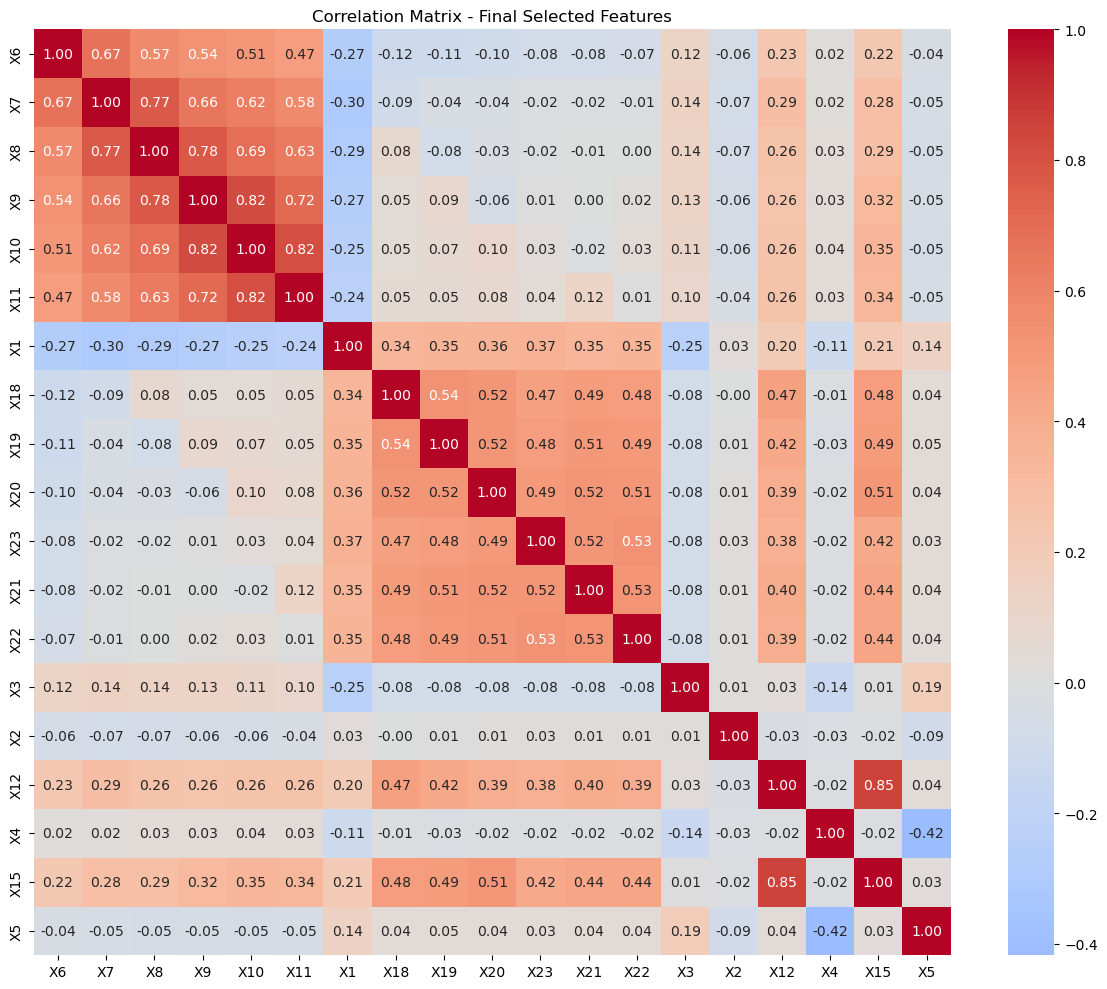


Final dataset shape: (30000, 20)


In [30]:
# Create final dataset
print("\nFinal Feature Selection")

X_final = X_reduced[significant_features]
data_final = pd.concat([X_final, y], axis=1)

print(f"Original number of features: {X.shape[1]}")
print(f"Features after multicollinearity removal: {X_reduced.shape[1]}")
print(f"Features after significance testing: {X_final.shape[1]}")
print(f"Final selected features: {list(X_final.columns)}")

# Display final correlation matrix
print("\nFinal correlation matrix:")
final_corr = X_final.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(final_corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Final Selected Features')
plt.tight_layout()
plt.show()

print(f"\nFinal dataset shape: {data_final.shape}")

### **Splitting Data**

In [31]:
X = data_final.drop('Y', axis=1)
y = data_final['Y']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=0.2,
    random_state=seed,
    stratify=y
)

In [33]:
# train test proportion
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 24000 samples
Test set size: 6000 samples


### **Imbalance Data Handling**

In [34]:
adasyn = ADASYN(random_state=seed)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

  File "c:\Users\loq\anaconda3\envs\tf-gpu-2_10\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\loq\anaconda3\envs\tf-gpu-2_10\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\loq\anaconda3\envs\tf-gpu-2_10\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\loq\anaconda3\envs\tf-gpu-2_10\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


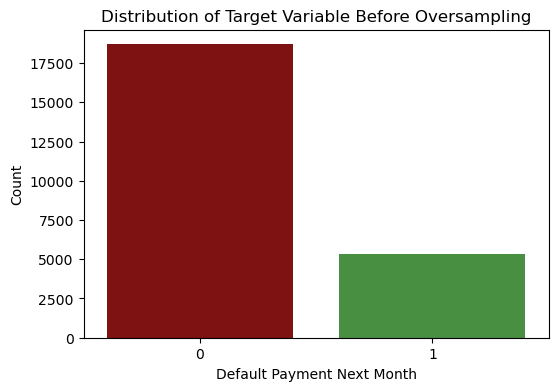

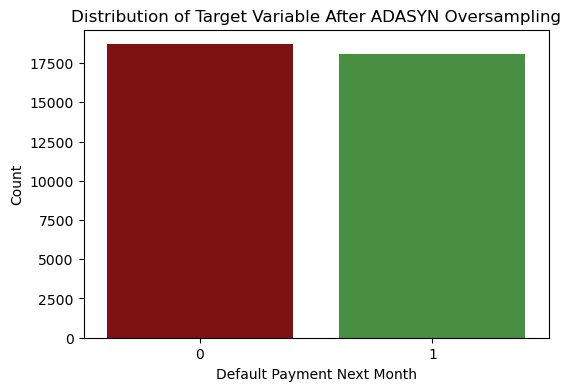

In [35]:
# data plot comparation before and after oversampling
# Before Oversampling
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=y_train, palette=['#900000', '#3e9c35'], ax=ax)
ax.set_title('Distribution of Target Variable Before Oversampling')
ax.set_xlabel('Default Payment Next Month')
ax.set_ylabel('Count')
plt.show()

# After Oversampling
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=y_train_balanced, palette=['#900000', '#3e9c35'], ax=ax)
ax.set_title('Distribution of Target Variable After ADASYN Oversampling')
ax.set_xlabel('Default Payment Next Month')
ax.set_ylabel('Count')
plt.show()

## **Modelling**
### **Model Parameters**

In [36]:
patience = 20
batch_size = 64
epochs = 200
callbacks = [
    EarlyStopping(
        monitor='val_loss', 
        patience=patience, 
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_model.h5', 
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

### **Model Architcture**

In [37]:
# Set seeds for reproducibility
tf.random.set_seed(seed)

model = keras.Sequential([
    # input layer
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # hidden layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    
    # output layer
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])

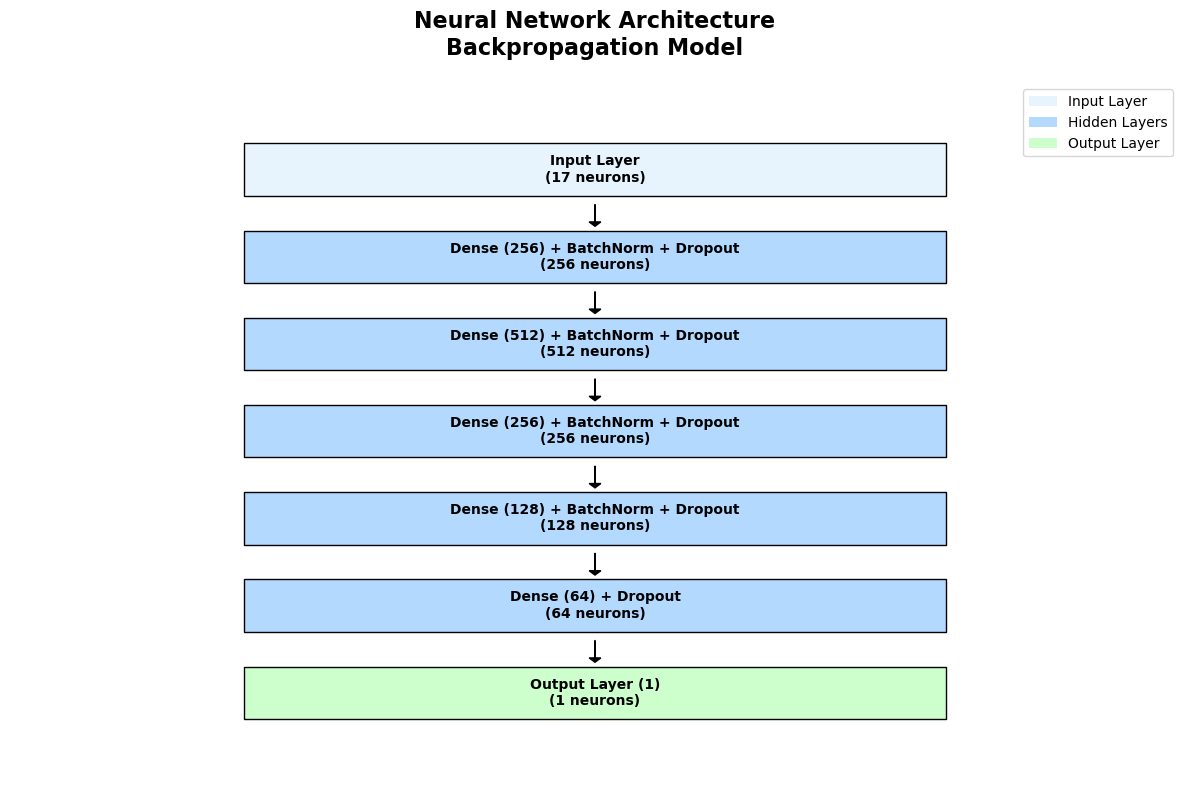

In [38]:
# Create a visual representation of the model architecture
def plot_model_architecture():
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Define layer information
    layers_info = [
        ('Input Layer', 17, '#e8f4fd'),
        ('Dense (256) + BatchNorm + Dropout', 256, '#b3d9ff'),
        ('Dense (512) + BatchNorm + Dropout', 512, '#b3d9ff'),
        ('Dense (256) + BatchNorm + Dropout', 256, '#b3d9ff'),
        ('Dense (128) + BatchNorm + Dropout', 128, '#b3d9ff'),
        ('Dense (64) + Dropout', 64, '#b3d9ff'),
        ('Output Layer (1)', 1, '#ccffcc')
    ]
    
    # Set up the plot
    ax.set_xlim(0, 10)
    ax.set_ylim(0, len(layers_info) + 1)
    
    # Draw layers
    for i, (layer_name, neurons, color) in enumerate(layers_info):
        y_pos = len(layers_info) - i
        
        # Draw rectangle for layer
        rect = plt.Rectangle((2, y_pos - 0.3), 6, 0.6, 
                            facecolor=color, edgecolor='black', linewidth=1)
        ax.add_patch(rect)
        
        # Add layer text
        ax.text(5, y_pos, f'{layer_name}\n({neurons} neurons)', 
                ha='center', va='center', fontsize=10, fontweight='bold')
        
        # Draw arrows between layers
        if i < len(layers_info) - 1:
            ax.arrow(5, y_pos - 0.4, 0, -0.2, head_width=0.1, 
                    head_length=0.05, fc='black', ec='black')
    
    # Add title and labels
    ax.set_title('Neural Network Architecture\nBackpropagation Model', 
                fontsize=16, fontweight='bold', pad=20)
    
    # Remove axes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='#e8f4fd', label='Input Layer'),
        plt.Rectangle((0, 0), 1, 1, facecolor='#b3d9ff', label='Hidden Layers'),
        plt.Rectangle((0, 0), 1, 1, facecolor='#ccffcc', label='Output Layer')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.savefig('model_architecture.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to display the architecture
plot_model_architecture()

### **Model Training**

In [39]:
history = model.fit(X_train, y_train_balanced,
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_split=0.2,
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/200
298/300 [============================>.] - ETA: 0s - loss: 0.5119 - accuracy: 0.7832
Epoch 1: val_accuracy improved from -inf to 0.80729, saving model to best_model.h5
300/300 [==============================] - 6s 10ms/step - loss: 0.5112 - accuracy: 0.7834 - val_loss: 0.4725 - val_accuracy: 0.8073 - lr: 0.0010
Epoch 2/200
294/300 [============================>.] - ETA: 0s - loss: 0.4646 - accuracy: 0.8065
Epoch 2: val_accuracy improved from 0.80729 to 0.81313, saving model to best_model.h5
300/300 [==============================] - 3s 9ms/step - loss: 0.4650 - accuracy: 0.8063 - val_loss: 0.4537 - val_accuracy: 0.8131 - lr: 0.0010
Epoch 3/200
300/300 [==============================] - ETA: 0s - loss: 0.4472 - accuracy: 0.8161
Epoch 3: val_accuracy did not improve from 0.81313
300/300 [==============================] - 3s 8ms/step - loss: 0.4472 - accuracy: 0.8161 - val_loss: 0.4481 - val_accuracy: 0.8112 - lr: 0.0010
Epoch 4/200
297/300 [============================>.] - E

## **Evaluation**

In [40]:
# Make predictions
model.load_weights('best_model.h5')
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Additional metrics
print("Additional Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

188/188 [==============================] - 1s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.65      0.38      0.48      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.66      0.69      6000
weighted avg       0.80      0.82      0.80      6000

Additional Metrics:
Accuracy: 0.8175
Precision: 0.6472
Recall: 0.3843
F1-Score: 0.4823


188/188 [==============================] - 0s 2ms/step
[[4395  278]
 [ 817  510]]


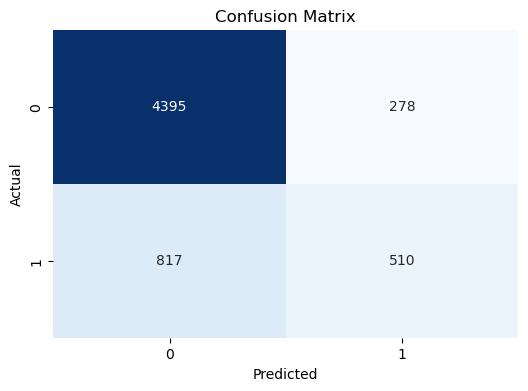

In [41]:
print(confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype("int32")))

# confusion matrix plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

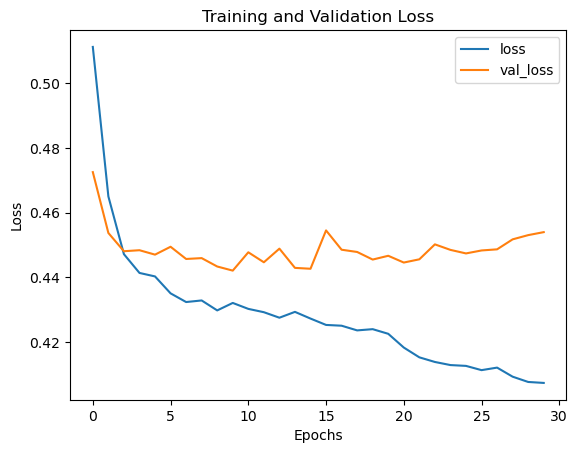

Minimum validation loss: 0.44206660985946655


In [42]:
if 'history' in locals() and history is not None:
	history_df = pd.DataFrame(history.history)
	history_df.loc[:, ['loss', 'val_loss']].plot()
	plt.title('Training and Validation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()
	plt.savefig('training_validation_loss.png', dpi=300, bbox_inches='tight')
	plt.show()
	print("Minimum validation loss: {}".format(history_df['val_loss'].min()))
else:
	print("History not available. Please re-run the training cell (cell 50) and assign model.fit() result to 'history' variable.")
	print("Example: history = model.fit(...)")

188/188 [==============================] - 0s 2ms/step


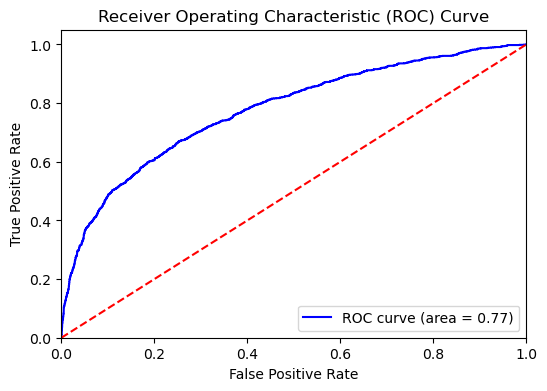

In [43]:
# roc-auc curve
from sklearn.metrics import roc_curve, auc
y_prob = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
98.7370 + (3.5951*37) + (0.1295*120)

247.29569999999998